In [358]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# possible promising outcome variables
- temperature
- light (on and off / on due to natural, on due to artificial, off)

Question: Based on visualization of light and motion, we see that light and motion are heavily correlated for sensor 2. As a result, if we wanted to put automated lights in this apartment, the sensor could do a good job of predicting when the light should be on of off, based on factors such as motion, temperature, humidity, scheduling (psets due), etc. This could be useful for light conservation.

## things to consider:
- cross validation
- scaling, normalizing
- validation data set
- confidence intervals
- resampling
- compute ttests
- find best predictors

# additional features:
- interaction : light (numerical value) x motion count
- polynomial terms
- predict sleep - binary indicator (1 if between 7-9 hours, 0 else)

In [359]:
df = pd.read_csv("all_data.csv").drop(columns=['Unnamed: 0'])

In [360]:
df

,day,hour,month,weekday,avg_hrly_hum,avg_hrly_temp,avg_hrly_press,tot_motion_count,avg_hrly_light,num_hrs_slept,num_psets_due
0,23,8,10,2,51.35,22.80,100858.130,0.0,4095.000000,6.46,3
1,29,22,10,1,54.20,20.50,102802.440,57.0,2155.500000,6.90,0
2,29,23,10,1,62.25,19.80,102801.110,26.0,3780.750000,6.90,0
3,30,0,10,2,65.15,20.15,102810.425,0.0,4095.000000,6.46,1
4,30,1,10,2,62.20,20.40,102802.390,0.0,4095.000000,6.46,1
...,...,...,...,...,...,...,...,...,...,...,...
761,6,7,12,4,19.10,15.75,101990.020,0.0,4095.000000,7.55,0
762,6,8,12,4,19.35,15.70,102007.570,20.0,4095.000000,7.55,0
763,6,9,12,4,19.45,15.65,101986.890,20.0,3662.333333,7.55,0
764,6,10,12,4,28.95,15.85,101894.715,124.0,3099.416667,7.55,0


In [361]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def standardize(train_df, val_df):
    # builtin standardscaler
    
    # fit on train df
    scaler = StandardScaler(with_mean=True) # with mean=True also centers before scaling
    scaler.fit(train_df)
    
    # transform train
    train_scaled = scaler.transform(train_df)
    scaled_train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
    
    # transform val
    val_scaled = scaler.transform(val_df)
    scaled_val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
    
    return scaled_train_df, scaled_val_df #, scaled_test_df

def scale(X_trian, X_test, y_train, y_test, cols_to_scale):
    X_train_pre = X_train[cols_to_scale]
    X_test_pre = X_test[cols_to_scale]
    X_train_scaled, X_test_scaled = standardize(X_train_pre, X_test_pre)
    
    X_train1 = X_train[X_train.columns.difference(cols_to_scale)]
    X_test1 = X_test[X_test.columns.difference(cols_to_scale)]
    
    X_train2 = pd.concat([X_train_scaled, X_train1], sort=False, axis=1)
    X_test2 = pd.concat([X_test_scaled, X_test1], sort=False, axis=1)
    return X_train2, X_test2

In [362]:
# split to train and test
train_data, test_data = train_test_split(df, test_size=0.2)

## Temperature

In [279]:
# temperature
X_train = train_data.drop(columns=['avg_hrly_temp'])
y_train = train_data['avg_hrly_temp']
X_test = test_data.drop(columns=['avg_hrly_temp'])
y_test = test_data['avg_hrly_temp']

cols_to_scale = ['avg_hrly_hum', 'avg_hrly_press', 'avg_hrly_light', 'tot_motion_count']
X_train2, X_test2 = scale(X_train, X_test, y_train, y_test, cols_to_scale)

In [280]:
# linear
model = LinearRegression().fit(X_train2, y_train)
print(model.score(X_train2, y_train))
print(model.score(X_test2, y_test))
lin_pred_train = model.predict(X_train2)
lin_pred_test = model.predict(X_test2)

# ridge
clf = Ridge(alpha=0.01)
clf.fit(X_train2, y_train)
print(clf.score(X_train2, y_train))
print(clf.score(X_test2, y_test))

# lasso
lasso = Lasso().fit(X_train2, y_train)
print(lasso.score(X_train2, y_train))
print(lasso.score(X_test2, y_test))

0.6129899715760312
0.5202566456164754
0.6129899578204367
0.5202410710257455
0.3586659046539963
0.318107576697627


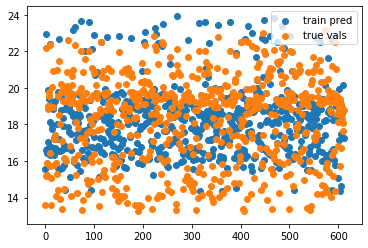

In [281]:
plt.scatter(np.arange(X_train2.shape[0]), lin_pred_train, label="train pred")
plt.scatter(np.arange(X_train2.shape[0]), y_train, label="true vals")
plt.legend()
plt.show()

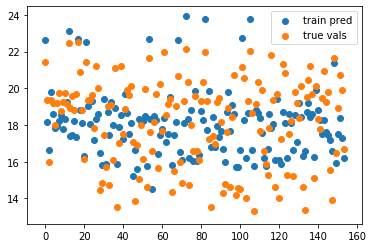

In [282]:
plt.scatter(np.arange(X_test2.shape[0]), lin_pred_test, label="train pred")
plt.scatter(np.arange(X_test2.shape[0]), y_test, label="true vals")
plt.legend()
plt.show()

## Light

In [287]:
light_status = []
for i in range(df.shape[0]):
    if df.loc[i,'avg_hrly_light'] == 4095.:
        light_status.append(0)
    else:
        light_status.append(1)


In [288]:
df['light_status'] = light_status

In [289]:
train_data, test_data = train_test_split(df, test_size=0.2)
X_train = train_data.drop(columns=['light_status','avg_hrly_light'])
y_train = train_data['light_status']
X_test = test_data.drop(columns=['light_status', 'avg_hrly_light'])
y_test = test_data['light_status']

In [290]:
cols_to_scale2 = ['avg_hrly_hum', 'avg_hrly_press', 'tot_motion_count', 'avg_hrly_temp']
X_train3, X_test3 = scale(X_train, X_test, y_train, y_test, cols_to_scale2)

In [304]:
# linear
model = LinearRegression().fit(X_train3, y_train)
print(model.score(X_train3, y_train))
print(model.score(X_test3, y_test))
lin_pred_train = model.predict(X_train3)
lin_pred_test = model.predict(X_test3)

# ridge
clf = Ridge(alpha=0.01)
clf.fit(X_train3, y_train)
print(clf.score(X_train3, y_train))
print(clf.score(X_test3, y_test))

# lasso
# lambdas = [0.01, 0.05, 0.1, 5, 10, 50, 100]
# , alphas=lam, max_iter=100000
# for lam in lambdas:
lasso = Lasso().fit(X_train3, y_train)
print(lasso.score(X_train3, y_train))
print(lasso.score(X_test3, y_test))

0.42982511354749475
0.5168249402312813
0.4298251111294402
0.5168369149898014
0.0
-0.0005103766674103838


Can try other models for classifying later ... if want to look at a different problem

Logistic Regression

- could look at misclassification rate for logistic vs linear

In [309]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter=100000).fit(X_train3, y_train)
print(logreg.score(X_train3, y_train))
print(logreg.score(X_test3, y_test))
log_pred_train = logreg.predict_proba(X_train3)
log_pred_test = logreg.predict_proba(X_test3)

0.9019607843137255
0.935064935064935


In [310]:
X_train.shape, X_test.shape

((612, 9), (154, 9))

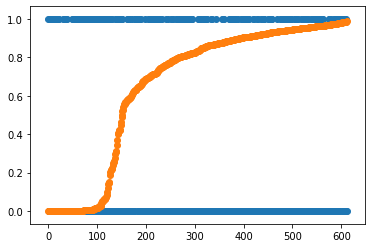

In [311]:
plt.scatter(np.arange(X_train.shape[0]), y_train)
plt.scatter(np.arange(X_train.shape[0]), np.sort(log_pred_train[:,0]))
plt.show()

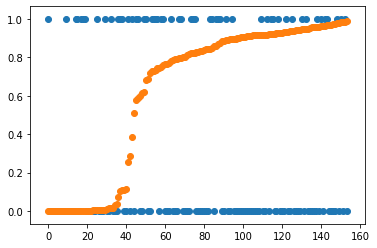

In [312]:
plt.scatter(np.arange(X_test.shape[0]), y_test)
plt.scatter(np.arange(X_test.shape[0]), np.sort(log_pred_test[:,0]))
plt.show()

# Sleep

In [363]:
df.head()

,day,hour,month,weekday,avg_hrly_hum,avg_hrly_temp,avg_hrly_press,tot_motion_count,avg_hrly_light,num_hrs_slept,num_psets_due
0,23,8,10,2,51.35,22.80,100858.130,0.0,4095.00,6.46,3
1,29,22,10,1,54.20,20.50,102802.440,57.0,2155.50,6.90,0
2,29,23,10,1,62.25,19.80,102801.110,26.0,3780.75,6.90,0
3,30,0,10,2,65.15,20.15,102810.425,0.0,4095.00,6.46,1
4,30,1,10,2,62.20,20.40,102802.390,0.0,4095.00,6.46,1


In [388]:
sleep_scores = []
for i in range(df.shape[0]):
    if (df.loc[i,'num_hrs_slept'] >= 7) and (df.loc[i,'num_hrs_slept'] <= 9):
        sleep_scores.append(1)
    else:
        sleep_scores.append(0)
df['sleep_score'] = sleep_scores
train_data, test_data = train_test_split(df, test_size=0.2)

In [389]:
cols_to_scale3 = ['avg_hrly_hum', 'avg_hrly_light', 'avg_hrly_press', 'tot_motion_count', 'avg_hrly_temp']
X_train = train_data.drop(columns=['num_hrs_slept', 'sleep_score'])
y_train = train_data['sleep_score']
X_test = test_data.drop(columns=['num_hrs_slept', 'sleep_score'])
y_test = test_data['sleep_score']

X_train4, X_test4 = scale(X_train, X_test, y_train, y_test, cols_to_scale3)

In [393]:
# linear
model = LinearRegression().fit(X_train4, y_train) #['tot_motion_count'].values.reshape(-1,1)
print(model.score(X_train4, y_train))
print(model.score(X_test4, y_test))
# lin_pred_train = model.predict(X_train4['tot_motion_count'])
# lin_pred_test = model.predict(X_test4['tot_motion_count'])

0.09019025776714185
0.06891739385917772


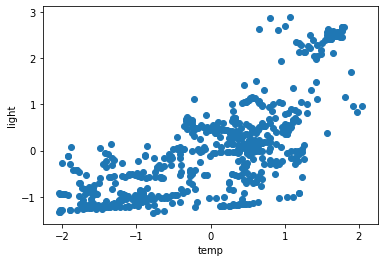

In [374]:
plt.scatter(X_train4['avg_hrly_temp'], X_train4['avg_hrly_hum'])
plt.xlabel("temp")
plt.ylabel("light")
plt.show()

Logistic Regression

In [394]:
logreg_sleep = LogisticRegression(solver = 'lbfgs', max_iter=100000).fit(X_train4, y_train)
print(logreg_sleep.score(X_train4, y_train))
print(logreg_sleep.score(X_test4, y_test))
# log_pred_train = logreg.predict_proba(X_train3)
# log_pred_test = logreg.predict_proba(X_test3)

0.7189542483660131
0.6753246753246753


Decision Tree